# Demand Forecasting using only time series features
In this experiment we only use *'totaldemand'* data. Our target variable is TOTALDEMAND and inputs are the timeseries features based on time series index
### Import necessary libraries

In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px 

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

import warnings
warnings.filterwarnings("ignore")

### Data Wrangling

In [2]:
tot_demand = pd.read_csv('/Users/nizam/Desktop/data/totaldemand_nsw.csv')
#tot_demand.dtypes # DATETIME is object
# convert to a datetime object
tot_demand['DATETIME'] = pd.to_datetime(tot_demand['DATETIME'])

# Check for duplicate DATETIME
duplicate_rows = tot_demand[tot_demand.duplicated(keep=False)] # keep=False to see all the duplicates

# drop duplicated rows
tot_demand = tot_demand.drop_duplicates()

# Set DATETIME feature as index
tot_demand_copy = tot_demand.copy()
tot_demand_idx=tot_demand_copy.set_index('DATETIME')
print(tot_demand_idx.head(3))


                    REGIONID  TOTALDEMAND
DATETIME                                 
2010-01-01 00:00:00     NSW1      7997.41
2010-01-01 00:05:00     NSW1      7946.51
2010-01-01 00:10:00     NSW1      7921.55


#### convert the Demand dataset into half hourly interval 

In [3]:
# Resample the Demand data frequency into half an hour
tot_demand_idx = pd.DataFrame(tot_demand_idx['TOTALDEMAND'].resample('30min').mean())


#### Create some functions

In [4]:
# root mean squared error (rsme)
def rmse(pred, actual): 
	return np.sqrt(((pred-actual)**2).mean())

# mean absolute percentage error (mape)
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Create time series features based on time series index
def create_features(df):
    df['YEAR'] = df.index.year
    df['MONTH'] = df.index.month
    df['DAY_OF_WEEK'] = df.index.dayofweek
    df['DAY'] = df.index.day
    df['HOUR'] = df.index.hour
    df['HALF_HOUR'] = df.index.minute//30
    
    return df

#### Create timeseries features

In [5]:
tot_demand_features = tot_demand_idx.copy()
tot_demand_features = create_features(tot_demand_features)
print(tot_demand_features .head(3))

                     TOTALDEMAND  YEAR  MONTH  DAY_OF_WEEK  DAY  HOUR  \
DATETIME                                                                
2010-01-01 00:00:00  7861.658333  2010      1            4    1     0   
2010-01-01 00:30:00  7552.563333  2010      1            4    1     0   
2010-01-01 01:00:00  7168.583333  2010      1            4    1     1   

                     HALF_HOUR  
DATETIME                        
2010-01-01 00:00:00          0  
2010-01-01 00:30:00          1  
2010-01-01 01:00:00          0  


## Forcasting using Machine Learning

#### Split the data into train and test

In [6]:
#data_inputx = tot_demand_features.drop(['TOTALDEMAND', 'REGIONID'], axis=1)
data_inputx = tot_demand_features.drop(['TOTALDEMAND'], axis=1)
data_inputy = tot_demand_features['TOTALDEMAND']

x_train = data_inputx[data_inputx.index.get_level_values(0) < '2021-01-01']
y_train = data_inputy[data_inputy.index.get_level_values(0) < '2021-01-01']

x_test = data_inputx[data_inputx.index.get_level_values(0) >= '2021-01-01']
y_test = data_inputy[data_inputy.index.get_level_values(0) >= '2021-01-01']

print(x_train.tail())
print(y_test.head())

                     YEAR  MONTH  DAY_OF_WEEK  DAY  HOUR  HALF_HOUR
DATETIME                                                           
2020-12-31 21:30:00  2020     12            3   31    21          1
2020-12-31 22:00:00  2020     12            3   31    22          0
2020-12-31 22:30:00  2020     12            3   31    22          1
2020-12-31 23:00:00  2020     12            3   31    23          0
2020-12-31 23:30:00  2020     12            3   31    23          1
DATETIME
2021-01-01 00:00:00    6879.418333
2021-01-01 00:30:00    6665.836667
2021-01-01 01:00:00    6314.523333
2021-01-01 01:30:00    6076.928333
2021-01-01 02:00:00    5860.276667
Freq: 30T, Name: TOTALDEMAND, dtype: float64


### Forecasting by using Linear Regression

In [7]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred_train = lr.predict(x_train)
y_pred_test1 = lr.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test1, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test1)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test1)

print("Train RMSE:",train_acc_rmse) # 1082.2850946353672
print("Test RMSE:",test_acc_rmse)   # 1124.1637904041963

print("Train MAE:",train_acc_mae ) # 856.4218807345167
print("Test MAE:",test_acc_mae)    # 867.923883565091

print("Train MAPE:",train_acc_mape) # 10.614017564564971
print("Test MAPE:",test_acc_mape)   # 11.228445538639788

# create a summary table
columns = ['Data', 'Model', 'MAPE', 'MAE', 'RMSE']
metrics = pd.DataFrame(columns = columns)
metrics.loc[0] = ['test','Linear Regression', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 1082.2850946353672
Test RMSE: 1124.1637904041963
Train MAE: 856.4218807345167
Test MAE: 867.923883565091
Train MAPE: 10.614017564564971
Test MAPE: 11.228445538639788


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.228446,867.923884,1124.16379


#### How well fits our model

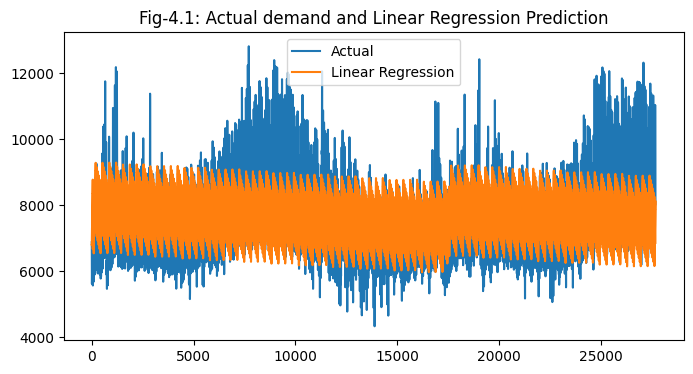

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test1, label='Linear Regression')
plt.title('Fig-4.1: Actual demand and Linear Regression Prediction')
plt.legend()
plt.show()

### Forecasting by using neural network (Multi-Layer Perceptron)

In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(12, ), activation='relu', solver='adam', random_state=1, alpha=0.1,max_iter=500, learning_rate_init = 0.1, tol=0)
mlp.fit(x_train,y_train)

y_pred_train = mlp.predict(x_train)
y_pred_test2 = mlp.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test2, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test2)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test2)

print("Train RMSE:",train_acc_rmse) # 1154.7767983749536
print("Test RMSE:",test_acc_rmse) # 1386.4255755941701

print("Train MAE:",train_acc_mae ) # 945.4811259007416
print("Test MAE:",test_acc_mae)    # 1187.1297067344426

print("Train MAPE:",train_acc_mape) # 12.118681688617912
print("Test MAPE:",test_acc_mape) # 16.550816888505143


metrics.loc[1] = ['test','Multi-Layer Perceptron', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 1154.7767983749536
Test RMSE: 1386.4255755941701
Train MAE: 945.4811259007416
Test MAE: 1187.1297067344426
Train MAPE: 12.118681688617912
Test MAPE: 16.550816888505143


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.228446,867.923884,1124.163790
1,test,Multi-Layer Perceptron,16.550817,1187.129707,1386.425576


#### How well fits our model

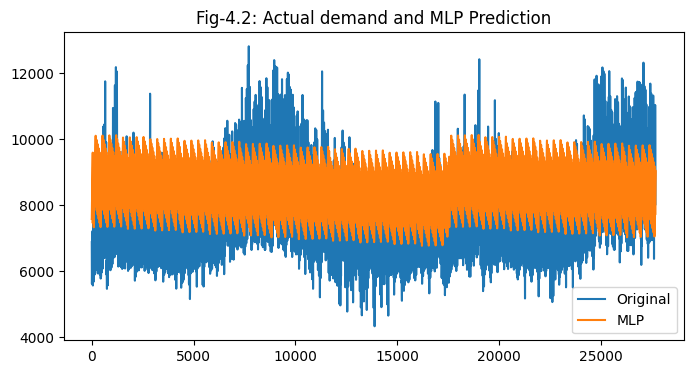

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Original')
plt.plot(y_pred_test2, label='MLP')
plt.title('Fig-4.2: Actual demand and MLP Prediction')
plt.legend()
plt.show()

#### Plot spread of predictions vs. actuals

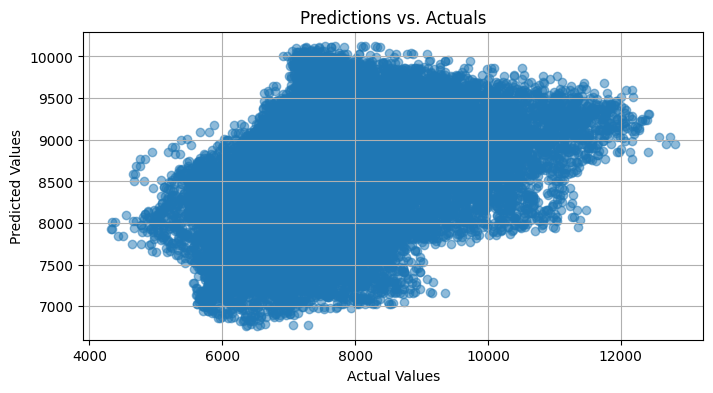

In [19]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred_test2, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actuals')
plt.grid(True)
plt.show()

### Forecasting by using Random Forest

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
}

rf = RandomForestRegressor(random_state=1)
best_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

best_rf.fit(x_train, y_train)

y_pred_train = best_rf.predict(x_train)
y_pred_test3 = best_rf.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test3, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test3)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test3)

print("Train RMSE:",train_acc_rmse) # 807.5747008918653
print("Test RMSE:",test_acc_rmse)   # 1076.3168255149656

print("Train MAE:",train_acc_mae ) # 590.0159203475837
print("Test MAE:",test_acc_mae)    # 826.6739932367017

print("Train MAPE:",train_acc_mape) # 7.129552176118549
print("Test MAPE:",test_acc_mape)   # 11.207443174414951

metrics.loc[2] = ['test','Random Forest', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 807.5747008918653
Test RMSE: 1076.3168255149656
Train MAE: 590.0159203475837
Test MAE: 826.6739932367017
Train MAPE: 7.129552176118549
Test MAPE: 11.207443174414951


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.228446,867.923884,1124.163790
1,test,Multi-Layer Perceptron,16.550817,1187.129707,1386.425576
2,test,Random Forest,11.207443,826.673993,1076.316826


#### How well fits our model

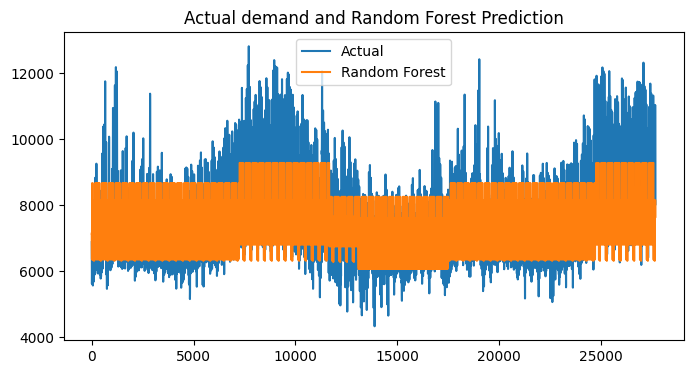

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test3, label='Random Forest')
plt.title('Actual demand and Random Forest Prediction')
plt.legend()
plt.show()

### Forecasting by using XGBoost

In [14]:
# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
xgb = XGBRegressor(random_state=1)
best_xgb = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

best_xgb.fit(x_train, y_train)

y_pred_train = best_xgb.predict(x_train)
y_pred_test4 = best_xgb.predict(x_test)

train_acc_rmse = rmse( y_pred_train, y_train) 
test_acc_rmse = rmse( y_pred_test4, y_test)

train_acc_mae = mean_absolute_error(y_train, y_pred_train)
test_acc_mae = mean_absolute_error( y_test,  y_pred_test4)

train_acc_mape = mape(y_train, y_pred_train) 
test_acc_mape = mape(y_test, y_pred_test4)

print("Train RMSE:",train_acc_rmse) # 519.7277263053804
print("Test RMSE:",test_acc_rmse) # 713.8652656801556

print("Train MAE:",train_acc_mae ) # 361.3311639157199
print("Test MAE:",test_acc_mae)    # 526.335176046161

print("Train MAPE:",train_acc_mape) # 4.328059897896404
print("Test MAPE:",test_acc_mape) # 7.016605832404366

metrics.loc[3] = ['test','XGBoost', test_acc_mape, test_acc_mae, test_acc_rmse]
metrics

Train RMSE: 519.7277263053804
Test RMSE: 713.8652656801556
Train MAE: 361.3311639157199
Test MAE: 526.335176046161
Train MAPE: 4.328059897896404
Test MAPE: 7.016605832404366


,Data,Model,MAPE,MAE,RMSE
0,test,Linear Regression,11.228446,867.923884,1124.163790
1,test,Multi-Layer Perceptron,16.550817,1187.129707,1386.425576
2,test,Random Forest,11.207443,826.673993,1076.316826
3,test,XGBoost,7.016606,526.335176,713.865266


#### Feature Importance

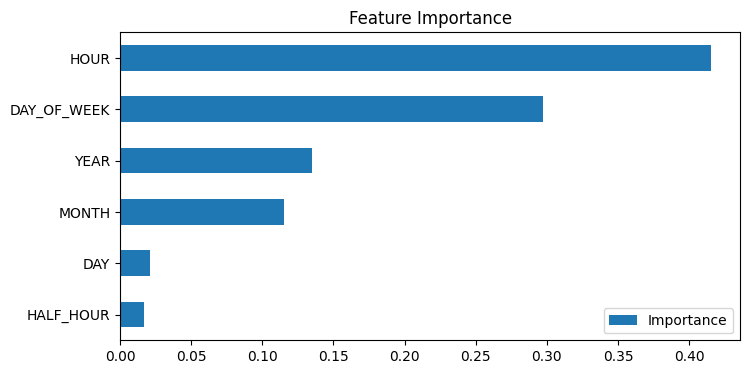

In [21]:
# create a dataframe with feature importances
feature_imp = pd.DataFrame(data=best_xgb.best_estimator_.feature_importances_,
                           index=best_xgb.feature_names_in_,
                          columns=['Importance'])

# plot the features according to their importance
feature_imp.sort_values('Importance').plot(kind='barh', title='Feature Importance', figsize=(8, 4))
plt.show()

### Plot the predicted demand on original demand

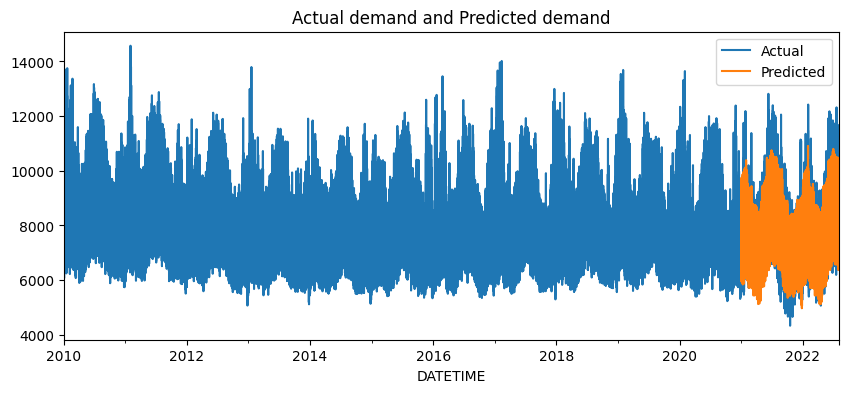

In [23]:
test_df =pd.DataFrame(y_test)
test_df['PREDICTION']= best_xgb.predict(x_test)
df = tot_demand_features.merge(test_df[['PREDICTION']], how = 'left', left_index=True, right_index=True)

# Plot
ax = df[['TOTALDEMAND']].plot(figsize=(10, 4))
test_df['PREDICTION'].plot(ax=ax, style='-')
plt.legend(['Actual', 'Predicted'])
ax.set_title('Actual demand and Predicted demand')
plt.show()

#### How well predict XGBoost

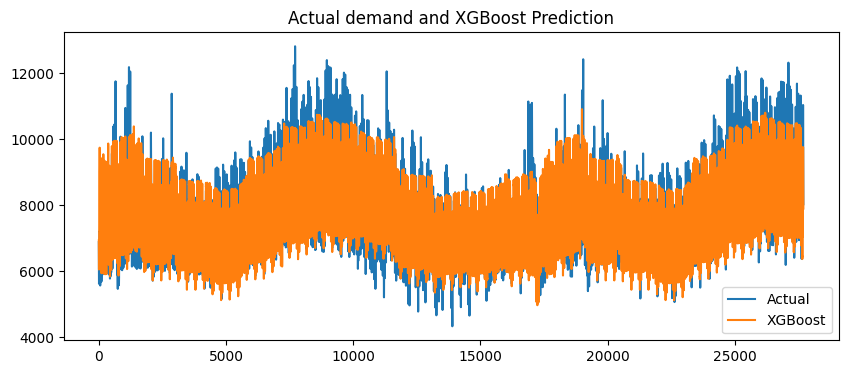

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test4, label='XGBoost')
plt.title('Actual demand and XGBoost Prediction')
plt.legend()
plt.show()